# Extraction of tangential interface velocity

The aim is to extract the tangential interface velocity from pseudo 3D (axis-symmetric 2D) VoF simulations. The interface velocity is then used to create a more realistic velocity boundary condition for single phase simulations of rising bubbles, which is necessary to account for the induced shear stress due to the internal motion of the bubble (which otherwise would be missing, e.g., when using a free-slip boundary condition instead). The steps to extract the interface velocity and to create a machine learning model for the boundary are:

* load the PLIC planes and the velocity field
* compute the center of each PLIC plane
* interpolate the velocity vector field to the PLIC center points
* compute the unit normal vector for each PLIC plane
* decompose the velocity vector in tangential and normal contribution (with respect to each plane)
* filter out some data points with bad quality
* train a MLP that takes the polar angle as features and returns the tangential velocity (magnitude) as label

In [1]:
import helper_module as hm
import glob
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition, mark_inset
import numpy as np
from sklearn.neighbors import KernelDensity
import torch

%matplotlib inline

# make torch results reproducible and use double precision
torch.set_default_tensor_type(torch.DoubleTensor)
torch.manual_seed(42)
np.random.seed(42)

data_path = "../data/"
bhaga_cases = glob.glob(data_path + "bhaga_0[2-4]_l16")
water_cases = glob.glob(data_path + "water_0[1-5]_l16")
cases = sorted(bhaga_cases + water_cases)
for i, case in enumerate(cases):
    print(i, case)

0 ../data/bhaga_02_l16
1 ../data/bhaga_03_l16
2 ../data/bhaga_04_l16
3 ../data/water_01_l16
4 ../data/water_03_l16
5 ../data/water_05_l16


## Load velocity fields, log-files, and PLIC elements

In [2]:
times = [30, 30, 20, 12, 14, 14] # Basilisk simulation time
Ga = [15.2400, 134.626, 30.8340, 98.6715, 163.450, 238.287]

all_fields = {}
all_facets = {}
for i, case in enumerate(cases):
    case_name = case.split("/")[-1]
    log_path = case + "/log." + case_name + ".csv"
    log = hm.Logfile(log_path)
    log.read_logfile(usecols=['time', 'u_x', 'x'])
    row = log.find_closest("time", times[i])
    plic_path = case + "/plic_clean/plic_{:06d}.pkl".format(row.index.values[0]*10)
    all_facets[case_name] = hm.FacetCollection2D(plic_path, [0, row.x.values[0]], True)
    field_path = case + "/" + case_name + "_t{:2d}.csv".format(times[i])
    all_fields[case_name] = hm.CenterFieldValues2D(field_path, [0.0, row.x.values[0]], [0.0, row.u_x.values[0]])
    print("")

Successfully read file ../data/bhaga_02_l16/log.bhaga_02_l16.csv
Successfully read file ../data/bhaga_02_l16/plic_clean/plic_062070.pkl
Successfully read file ../data/bhaga_02_l16/bhaga_02_l16_t30.csv

Successfully read file ../data/bhaga_03_l16/log.bhaga_03_l16.csv
Successfully read file ../data/bhaga_03_l16/plic_clean/plic_089590.pkl
Successfully read file ../data/bhaga_03_l16/bhaga_03_l16_t30.csv

Successfully read file ../data/bhaga_04_l16/log.bhaga_04_l16.csv
Successfully read file ../data/bhaga_04_l16/plic_clean/plic_036380.pkl
Successfully read file ../data/bhaga_04_l16/bhaga_04_l16_t20.csv

Successfully read file ../data/water_01_l16/log.water_01_l16.csv
Successfully read file ../data/water_01_l16/plic_clean/plic_1045900.pkl
Successfully read file ../data/water_01_l16/water_01_l16_t12.csv

Successfully read file ../data/water_03_l16/log.water_03_l16.csv
Successfully read file ../data/water_03_l16/plic_clean/plic_871610.pkl
Successfully read file ../data/water_03_l16/water_03_l1

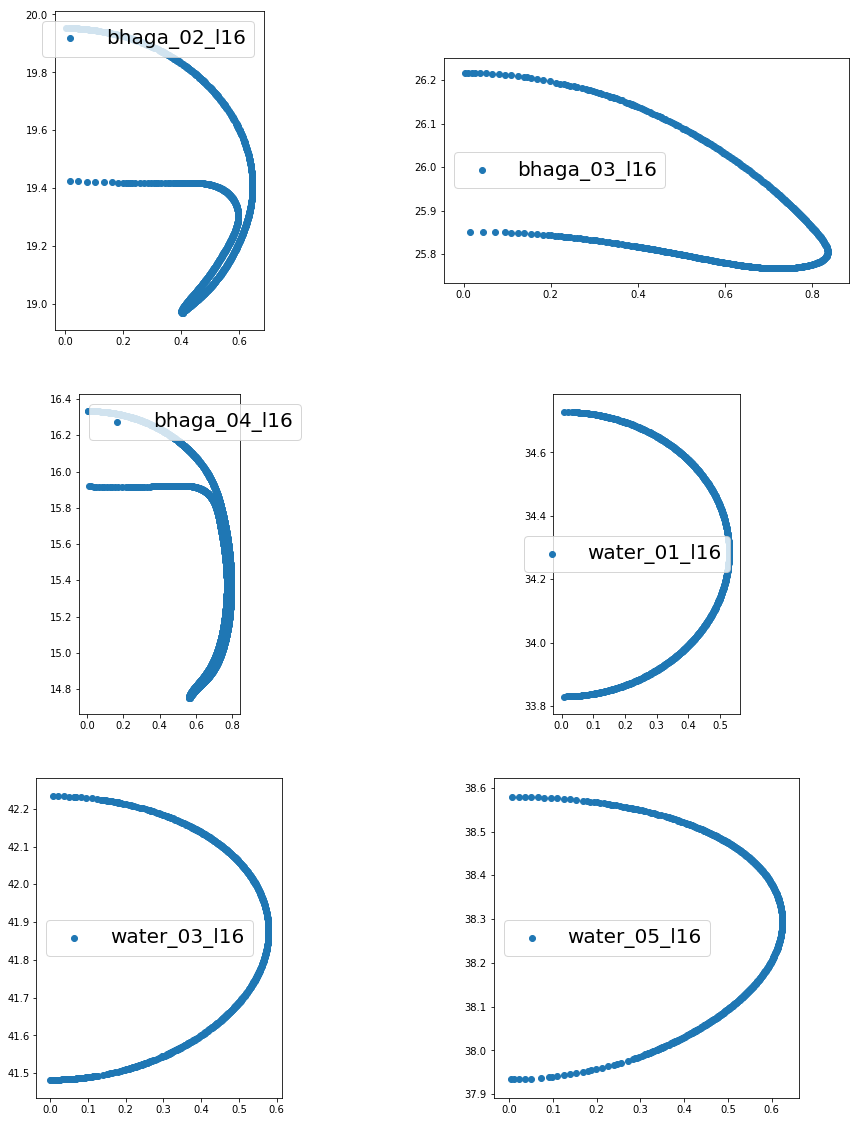

In [6]:
rc('text', usetex=False)
fig, axarr = plt.subplots(3, 2, figsize=(hm.figure_width, 20))

index = [(i,j) for i in range(3) for j in range(2)]

for i, case in enumerate(cases):
    case_name = case.split("/")[-1]
    row, col = index[i]
    c_x, c_y = all_facets[case_name].get_facet_centers(polar=False)
    axarr[row, col].scatter(c_x, c_y, label=case_name)
    axarr[row, col].set_aspect("equal")
    axarr[row, col].legend(fontsize=hm.fontsize_legend)

In [ ]:
import pickle
import os

class PlicCollection():
    def __init__(self, path, bubble_center, fields, flipXY=False, moveOriginBottom=False):
        self.path = path
        self.bubble_center = bubble_center
        self.fields = fields
        self.flipXY = flipXY
        self.moveOriginBottom = moveOriginBottom
        self.read_plic()
        self.compute_centers()
        self.compute_unit_normals()
        self.compute_polar_coordinates()
        
    def read_plic(self):
        assert os.path.isfile(self.path), "File {} does not exist.".format(self.path)
        file = open(self.path, 'rb')
        self.data = pickle.load(file)
        file.close()
        self.data.drop(["element"], axis=1, inplace=True)
        if self.flipXY:
            self.data.rename(columns={"px":"py", "py":"px"}, inplace=True)
        if self.moveOriginBottom:
            self.min_y = np.min(self.data.py.values)
            self.data["py"] = self.data.py.values - self.min_y
        else:
            self.data["py"] = self.data.py.values - self.bubble_center
        self.plic_elements = np.asarray([[(self.data.px.values[e], self.data.py.values[e]), (self.data.px.values[e+1], self.data.py.values[e+1])]
                   for e in range(0, self.data.shape[0]-1, 2)])
        
    def get_plic_elements(self):
        return self.plic_elements
        
    def compute_centers(self):
        self.plic_centers = np.zeros((self.plic_elements.shape[0], 2))
        for i, p12 in enumerate(self.plic_elements):
            p1, p2 = p12
            self.plic_centers[i] = 0.5 * (p1 + p2)
            
    def get_centers(self):
        return self.plic_centers
    
    def compute_unit_normals(self):
        self.unit_normals = np.zeros((self.plic_elements.shape[0], 2))
        for i, p12 in enumerate(self.plic_elements):
            p1, _ = p12
            diff = p1 - self.plic_centers[i]
            normal = np.asarray([diff[1], -diff[0]])
            ref_plus = self.plic_centers[i] + normal
            ref_min = self.plic_centers[i] - normal
            if self.moveOriginBottom:
                ref_plus[1] = ref_plus[1] + self.min_y - self.bubble_center
                ref_min[1] = ref_min[1] + self.min_y - self.bubble_center
            grad_f = self.fields.get_volume_fraction(ref_plus[0], ref_plus[1]) - self.fields.get_volume_fraction(ref_min[0], ref_min[1])
            self.unit_normals[i] = normal / np.linalg.norm(normal) * np.sign(grad_f)
            
    def get_unit_normals(self):
        return self.unit_normals
    
    def get_unit_tangentials(self):
        unit_tangentials = np.zeros(self.unit_normals.shape)
        for i, normal in enumerate(self.unit_normals):
            unit_tangentials[i] = np.asarray([normal[1], -normal[0]])
        return unit_tangentials
    
    def project_velocity_normal(self, vectorial=True):
        u_vector = self.plic_center_velocity()
        normal_velocity = np.asarray([np.sum(u_vector * self.unit_normals, axis=1)]).T
        if vectorial:
            return normal_velocity * self.unit_normals
        else:
            return normal_velocity
    
    def project_velocity_tangential(self, vectorial=True):
        u_vector = self.plic_center_velocity()
        unit_t = self.get_unit_tangentials()
        tangential_velocity = np.asarray([np.sum(u_vector * unit_t, axis=1)]).T
        if vectorial:
            return tangential_velocity * unit_t
        else:
            return tangential_velocity
        
    def plic_center_velocity(self):
        if self.moveOriginBottom:
            ux, uy = self.fields.get_reynolds(self.plic_centers[:,0], self.plic_centers[:,1]+self.min_y-self.bubble_center, relative=True, magnitude=False)
        else:
            ux, uy = self.fields.get_reynolds(self.plic_centers[:,0], self.plic_centers[:,1], relative=True, magnitude=False)
        return np.asarray([ux, uy]).T
    
    def get_polar_coordinates(self):
        return self.radius, self.phi
    
    def compute_polar_coordinates(self):
        self.radius = np.sqrt(np.square(self.plic_centers[:,0]) + np.square(self.plic_centers[:,1]))
        self.phi = np.arccos(self.plic_centers[:,1] / self.radius)
        
        
        
        
# the iterations corresponding to the physical times have been determined in the notebook
# "Mesh dependency of axis-symmetric bubbles velocities and shapes"

base_path = "/media/weiner/Volume/basilisk/basilisk/"
plic_path = [
    "bhaga_02_l16/plic_clean/plic_062070.pkl",
    "bhaga_03_l16/plic_clean/plic_089590.pkl",
    "bhaga_04_l16/plic_clean/plic_036380.pkl",
    "water_01_l16/plic_clean/plic_1045900.pkl",
    "water_03_l16/plic_clean/plic_871610.pkl",
    "water_05_l16/plic_clean/plic_677920.pkl"
]

plic_collections = {}
for i, case in enumerate(plic_path):
    name = case.split("/")[0]
    if name in ["bhaga_02_l16", "bhaga_04_l16"]:
        moveOriginBottom = True
    else:
        moveOriginBottom = False
    plic_collections[name] = PlicCollection(base_path+case, bubble_center=bubble_centers[i],
                                            fields = all_fields[i], flipXY=True, moveOriginBottom=moveOriginBottom)
    
    

    
rc('text', usetex=False)

case = plic_collections["bhaga_02_l16"]
centers = case.get_centers()
elements = case.get_plic_elements()
normals = case.get_unit_normals()
tangentials = case.get_unit_tangentials()
u_vec = case.plic_center_velocity()
u_t = case.project_velocity_tangential(vectorial=True)
u_n = case.project_velocity_normal(vectorial=True)

print(np.max(u_vec - u_t - u_n))

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
scale = 0.001
for i, p12 in enumerate(elements[:400]):
    p1, p2 = p12
    #ax.plot([p1[0], p2[0]], [p1[1], p2[1]])
    #ax.scatter(centers[i][0], centers[i][1])
    ax.quiver(centers[i][0], centers[i][1], normals[i][0], normals[i][1], width=0.003)
    #ax.quiver(centers[i][0], centers[i][1], tangentials[i][0], tangentials[i][1], width=0.003)
    #ax.quiver(centers[i][0], centers[i][1], u_n[i][0], u_n[i][1], width=0.003)
    #ax.quiver(centers[i][0], centers[i][1], u_t[i][0], u_t[i][1], width=0.003)
ax.set_aspect('equal')
plt.show()


keys = plic_collections.keys()
size = 80
lw = 0.5
u_tol_frac = [0.04, 0.04, 0.04, 0.02, 0.02, 0.02]

fig, axarr = plt.subplots(len(keys), 1, sharex=False, figsize=(16, 5*len(keys)))
for i, case in enumerate(plic_collections.keys()):
    plic = plic_collections[case]
    rad, phi = plic.get_polar_coordinates()
    u_t = plic.project_velocity_tangential(vectorial=False)
    u_t_vec = plic.project_velocity_tangential(vectorial=True)
    u_n = plic.project_velocity_normal(vectorial=False)
    u_n_vec = plic.project_velocity_normal(vectorial=True)
    u_tol = np.amax(np.absolute(u_t)) * u_tol_frac[i]
    print(u_tol)
    outliers = np.linalg.norm(u_n_vec, axis=1) < u_tol
    axarr[i].scatter(phi, u_n, marker="+", color='C0', s=size, lw=lw, label=r"$u_{n}$")
    axarr[i].scatter(phi, u_t, marker="x", color='C1', s=size, lw=lw, label=r"$u_{t}$")
    #axarr[i].scatter(phi, u_t[:,0], marker="*", facecolors='none', edgecolors='C0', s=size, lw=lw, label=r"$u_{tx}$")
    #axarr[i].scatter(phi, u_t[:,1], marker="+", c='C1', s=size, lw=lw, label=r"$u_{ty}$")
    #axarr[i].scatter(phi, np.linalg.norm(u_t, axis=1), marker="<", facecolors='none', edgecolors='C2', s=size, lw=lw, label=r"$|\mathbf{u}_{t}|$")
    axarr[i].scatter(np.ma.masked_array(phi, mask=outliers), np.ma.masked_array(u_t, mask=outliers), marker="o", facecolors='none', edgecolors='C3', s=size, lw=lw)
    #axarr[i].scatter(np.ma.masked_array(phi, mask=outliers), np.ma.masked_array(u_t[:,1], mask=outliers), marker="o", facecolors='none', edgecolors='C3', s=size, lw=lw)
    axarr[i].set_ylabel(r"$u_t$ in $-$")
    #axarr[i].set_xlim(0.0, np.pi)
    axarr[i].legend()
    
axarr[-1].set_xlabel(r"$\varphi$")





fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15, 6))
lw=1.0
rc('text', usetex=True)

plic = plic_collections["water_03_l16"]
rad, phi = plic.get_polar_coordinates()
mag_u_t = np.linalg.norm(plic.project_velocity_tangential(vectorial=True), axis=1)
mag_u_n = np.linalg.norm(plic.project_velocity_normal(vectorial=True), axis=1)
u_tol = np.amax(mag_u_t) * 0.02
# the criteron is inverted for the masked_array function
outliers = mag_u_n < u_tol

ax.scatter(phi, mag_u_n, marker="+", edgecolors='C0', s=size, lw=lw, label=r"$|\mathbf{\bar{u}_{\bot}}|$")
ax.scatter(phi, mag_u_t, marker="x", edgecolors='C1', s=size, lw=lw, label=r"$|\mathbf{\bar{u}_{\parallel}}|$")

ax.scatter(np.ma.masked_array(phi, mask=outliers), np.ma.masked_array(mag_u_t, mask=outliers),
           marker="o", facecolors='none', edgecolors='C3', s=size, lw=lw, label="outliers")
ax.axhline(u_tol, 0.0, 1.0, ls="--", lw=2, color="k", label=r"$U_{tol}$")

ax.set_xlabel(r"$\varphi$", fontsize=fontsize_labels)
ax.set_xlim(0.0, np.pi)
ax.set_ylabel(r"$|\mathbf{\bar{u}_\Sigma}|$", fontsize=fontsize_labels)
ax.legend(fontsize=fontsize_labels)
ax.tick_params(labelsize=fontsize_ticks)
ax.text(0.2, 600, r"$U_{tol} = 0.02\mathrm{max}(|\mathbf{\bar{u}_{\parallel}}|)$", horizontalalignment='left', verticalalignment='bottom', fontsize=fontsize_labels)
plt.savefig("marked_outliers.pdf", bbox_inches="tight")
plt.savefig("marked_outliers.png", bbox_inches="tight")



keys = plic_collections.keys()
u_tol_frac = [0.04, 0.04, 0.04, 0.02, 0.02, 0.02]

phi_clean = {}
rad_clean = {}
u_t_clean = {}

for i, case in enumerate(plic_collections.keys()):
    plic = plic_collections[case]
    rad, phi = plic.get_polar_coordinates()
    u_t = plic.project_velocity_tangential(vectorial=False)
    u_n = plic.project_velocity_normal(vectorial=False)
    u_tol = np.amax(np.absolute(u_t)) * u_tol_frac[i]
    outliers = np.absolute(u_n) < u_tol
    phi_clean[case] = phi[outliers.squeeze(axis=1)]
    rad_clean[case] = rad[outliers.squeeze(axis=1)]
    u_t_clean[case] = u_t[outliers]
    print("Marked {} out of {} cells as outlier for case {}.".format(outliers.shape[0]-np.count_nonzero(outliers), u_t.shape[0], case))
    
    
    !mkdir -p models

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
rc('text', usetex=False)

for i, case in enumerate(["bhaga_03_l16", "water_01_l16", "water_03_l16", "water_05_l16"]):
    u_t = u_t_clean[case]
    u_t_norm = (u_t - np.min(u_t)) / (np.max(u_t) - np.min(u_t))
    phi_tensor = torch.from_numpy(phi_clean[case]).unsqueeze(-1)
    u_t_tensor = torch.from_numpy(u_t_norm)
    model = SimpleMLP(n_layers=6, n_neurons=60, activation=torch.relu)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    loss_epochs = []
    best_loss = 1.0E5
    for e in range(1, 1001):
        optimizer.zero_grad()
        output = model.forward(phi_tensor)
        loss = criterion(output.squeeze(dim=1), u_t_tensor)
        loss.backward()
        optimizer.step()
        loss_epochs.append(loss.item())
        if loss_epochs[-1] < best_loss:
            min_loss = loss_epochs[-1]
            torch.save(model.state_dict(), "models/u_t_" + case + "_best.pt")
    ax.plot(range(1, 1001), loss_epochs, label=case)
            
ax.set_yscale('log')
ax.legend()
plt.show()





rc('text', usetex=True)
labels = ["Bhaga, case e)", "water/air, $d_b=1mm$", "water/air, $d_b=1.4mm$", "water/air, $d_b=1.8mm$"]

fig, axarr = plt.subplots(4, 1, sharex=True, figsize=(15, 20))
for i, case in enumerate(["bhaga_03_l16", "water_01_l16", "water_03_l16", "water_05_l16"]):
    axarr[i].scatter(phi_clean[case], u_t_clean[case], color="C1", s=80, marker="x", lw=0.5, label=labels[i])
    axarr[i].set_xlim(0.0, np.pi)
    phi_eval = torch.from_numpy(np.linspace(0.0, np.pi, 200)).unsqueeze(-1)
    model = SimpleMLP(n_layers=6, n_neurons=60, activation=torch.relu)
    model.load_state_dict(torch.load("models/u_t_" + case + "_best.pt"))
    u_t_m = model.forward(phi_eval).detach().numpy().squeeze(axis=1)
    u_t_m = u_t_m * (np.max(u_t_clean[case]) - np.min(u_t_clean[case])) + np.min(u_t_clean[case])
    axarr[i].plot(phi_eval.numpy().squeeze(axis=1), u_t_m, color="k", lw=2, label="model")
    axarr[i].legend(fontsize=fontsize_labels)
    axarr[i].set_ylabel(r"$\mathbf{\overline{u}_\Sigma}\cdot \mathbf{\tau}$", fontsize=fontsize_labels)
    axarr[i].tick_params(labelsize=fontsize_ticks)
    
axarr[-1].set_xlabel(r"$\varphi$", fontsize=fontsize_labels)
plt.savefig("u_t_simple.pdf", bbox_inches="tight")
plt.savefig("u_t_simple.png", bbox_inches="tight")



model_base_path = "../shapes/models/"

phi_inout = {}
u_t_inout = {}

fig, axarr = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

for i, case in enumerate(["bhaga_02_l16", "bhaga_04_l16"]):
    phi_tensor = torch.from_numpy(phi_clean[case]).unsqueeze(-1)
    inner_rad = SimpleMLP(n_layers=6, n_neurons=60, activation=torch.sigmoid)
    outer_rad = SimpleMLP(n_layers=6, n_neurons=60, activation=torch.sigmoid)
    inner_rad.load_state_dict(torch.load(model_base_path + case + "_inner.pt"))
    outer_rad.load_state_dict(torch.load(model_base_path + case + "_outer.pt"))
    dist_inner = np.absolute(rad_clean[case] - inner_rad.forward(phi_tensor).detach().numpy().squeeze(axis=1))
    dist_outer = np.absolute(rad_clean[case] - outer_rad.forward(phi_tensor).detach().numpy().squeeze(axis=1))
    inner_contour = dist_inner < dist_outer
    outer_contour = dist_outer < dist_inner
    phi_inout[case + "-inner"] = phi_clean[case][inner_contour]
    phi_inout[case + "-outer"] = phi_clean[case][outer_contour]
    u_t_inout[case + "-inner"] = u_t_clean[case][inner_contour]
    u_t_inout[case + "-outer"] = u_t_clean[case][outer_contour]
    print("Case {}:".format(case))
    print("Found {} points on inner contour and {} points on outer contour ({} total points).".format(
    phi_inout[case + "-inner"].shape[0], phi_inout[case + "-outer"].shape[0], phi_inout[case + "-inner"].shape[0] + phi_inout[case + "-outer"].shape[0]))
    axarr[i].scatter(phi_inout[case + "-inner"], u_t_inout[case + "-inner"], marker="x", label="inner")
    axarr[i].scatter(phi_inout[case + "-outer"], u_t_inout[case + "-outer"], marker="x", label="outer")
    axarr[i].legend()
    axarr[i].set_xlim(0, 0.5*np.pi)
    
    
    
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
rc('text', usetex=False)

epochs = 2000

for i, case in enumerate(phi_inout.keys()):
    u_t = u_t_inout[case]
    u_t_norm = (u_t - np.min(u_t)) / (np.max(u_t) - np.min(u_t))
    u_t_tensor = torch.from_numpy(u_t_norm)
    phi_tensor = torch.from_numpy(phi_inout[case]).unsqueeze(-1)
    phi90 = torch.ones(1,1) * np.pi * 0.5
    u_t90 = torch.ones(1) * (0.0 - np.min(u_t)) / (np.max(u_t) - np.min(u_t))
    print(case, u_t90)
    model = SimpleMLP(n_layers=6, n_neurons=80, activation=torch.sigmoid)
    criterion_1 = torch.nn.MSELoss()
    criterion_2 = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    loss_epochs = []
    loss_1_epochs = []
    loss_2_epochs = []
    best_loss = 1.0E5
    for e in range(1, epochs + 1):
        optimizer.zero_grad()
        output = model.forward(phi_tensor)
        output_phi90 = model.forward(phi90)
        loss_1 = criterion_1(output.squeeze(dim=1), u_t_tensor)
        loss_2 = criterion_2(output_phi90.squeeze(dim=1), u_t90)
        loss = loss_1 + loss_2
        loss.backward()
        optimizer.step()
        loss_epochs.append(loss.item())
        loss_1_epochs.append(loss_1.item())
        loss_2_epochs.append(loss_2.item())
        if loss_epochs[-1] < best_loss:
            min_loss = loss_epochs[-1]
            torch.save(model.state_dict(), "models/u_t_" + case + ".pt")
    ax.plot(range(1, epochs + 1), loss_epochs, label=case)
    ax.plot(range(1, epochs + 1), loss_1_epochs, ls="--", label=case + ", loss 1")
    ax.plot(range(1, epochs + 1), loss_2_epochs, ls=":", label=case + ", loss 2")
            
ax.set_yscale('log')
ax.legend()
plt.show()




rc('text', usetex=True)
labels = ["Bhaga, case d)", "Bhaga, case g)"]

fig, axarr = plt.subplots(2, 1, sharex=True, figsize=(15, 10))
for i, case in enumerate(["bhaga_02_l16", "bhaga_04_l16"]):
    axarr[i].scatter(phi_inout[case + "-inner"], u_t_inout[case + "-inner"], s=80, marker="x", lw=0.5, label=labels[i] + ", inner")
    axarr[i].scatter(phi_inout[case + "-outer"], u_t_inout[case + "-outer"], s=80, marker="x", lw=0.5, label=labels[i] + ", outer")
    axarr[i].set_xlim(0.0, np.pi/2)
    phi_tensor = torch.from_numpy(np.linspace(0.0, 0.5*np.pi, 200)).unsqueeze(-1)
    inner_model = SimpleMLP(n_layers=6, n_neurons=80, activation=torch.sigmoid)
    outer_model = SimpleMLP(n_layers=6, n_neurons=80, activation=torch.sigmoid)
    inner_model.load_state_dict(torch.load("models/u_t_" + case + "-inner.pt"))
    outer_model.load_state_dict(torch.load("models/u_t_" + case + "-outer.pt"))
    u_t_in = inner_model.forward(phi_tensor).detach().numpy().squeeze(axis=1)
    u_t_out = outer_model.forward(phi_tensor).detach().numpy().squeeze(axis=1)
    u_t_in = u_t_in * (np.max(u_t_inout[case + "-inner"]) - np.min(u_t_inout[case + "-inner"])) + np.min(u_t_inout[case + "-inner"])
    u_t_out = u_t_out * (np.max(u_t_inout[case + "-outer"]) - np.min(u_t_inout[case + "-outer"])) + np.min(u_t_inout[case + "-outer"])
    axarr[i].plot(phi_tensor.numpy(), u_t_in, color="k", lw=2, label="model, inner")
    axarr[i].plot(phi_tensor.numpy(), u_t_out, color="k", lw=2, label="model, outer")
    axarr[i].legend(fontsize=fontsize_labels)
    axarr[i].set_ylabel(r"$\mathbf{\overline{u}_\Sigma}\cdot \mathbf{\tau}$", fontsize=fontsize_labels)
    axarr[i].tick_params(labelsize=fontsize_ticks)
    axarr[i].axhline(0.0, 0.0, 1.0, ls="--", c="k")
    
axarr[-1].set_xlabel(r"$\varphi$", fontsize=fontsize_labels)
plt.savefig("u_t_complex.pdf", bbox_inches="tight")
plt.savefig("u_t_complex.png", bbox_inches="tight")